<center>
<h1><b>Revealing the Mechanism of WeChat Red Envelopes<b>
</center>

<center>
 Lei Qian 2024533134
</center>
<center>
 Jingqi Xu 2024533083
</center>
<center>
 Zihao Zhang 2024533113
</center>

<center>
date:2025/12/08 
</center>

## **1.Observation**

  To ensure the representativeness and comprehensiveness of the data, experimental scenarios with "WeChat group size" as the core variable are designed, covering two typical scales:

**3-person (small private group)**

Focus on exploring the red envelope distribution pattern in intimate, small-scale interaction scenarios. The total red envelope amount is fixed at 20 yuan, and the experiment is repeated 120 times to ensure the statistical significance of the sample.

**15-person (medium-sized social group)**

Aim to reflect the distribution characteristics in semi-public social scenarios (e.g., friend groups, interest groups). To capture the impact of different total amounts on user behavior, two types of total red envelope amounts are included to enrich the sample diversity: 

1.60 yuan per red envelope, repeated 150 times; 

2.0.6 yuan per red envelope (low-amount scenario), repeated 150 times.

## **2.Visualization**

To intuitively reveal the distribution characteristics, dispersion degree, and correlation between key variables of WeChat red envelope received amounts, this study adopts three types of visualization tools—histograms, box plots, and scatter plots—based on standardized experimental data, with plots generated using Python's matplotlib libraries. The detailed results are as follows:


##### **1.histograms**

we draw histograms for each order,indicate the relation ship between the sum money and the probability.

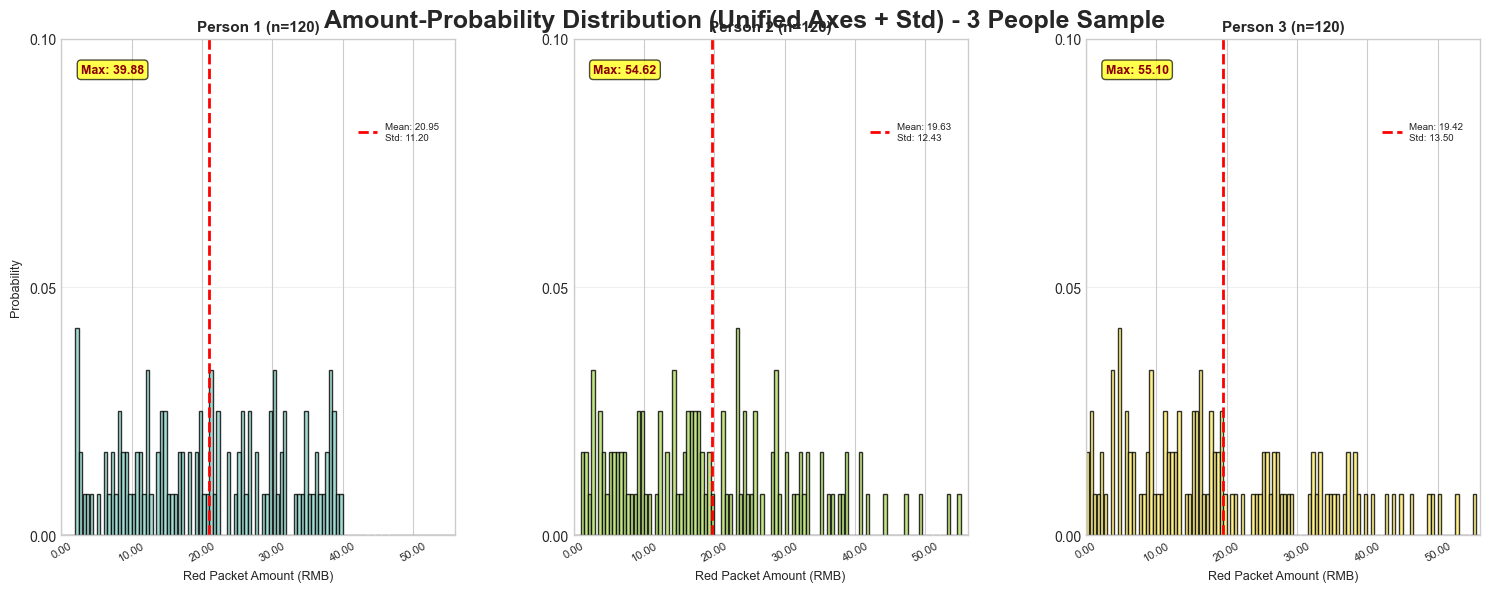

=== Key Statistics (Exact to 0.01 RMB) - 3 People Sample ===
  Person  Sample Size Mean (RMB) Std (RMB) Variance (RMB²) Max (RMB)
Person 1          120      20.95     11.20        125.4400     39.88
Person 2          120      19.63     12.43        154.5049     54.62
Person 3          120      19.42     13.50        182.2500     55.10


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel("E:/gailvlun/SI140A-proj/Data/3/3人总.xls", sheet_name="Sheet1", header=None)

grab_order_data = df.iloc[1:-1, :3].values.astype(float).round(2)
all_valid_data = grab_order_data[~np.isnan(grab_order_data)]
global_min = (
    np.floor(all_valid_data.min()) if len(all_valid_data) > 0 else 0
) 
global_max = (
    np.ceil(all_valid_data.max()) if len(all_valid_data) > 0 else 10
) 
grab_order_labels = [f"Person {i+1}" for i in range(3)] 

bin_width = 0.50
bin_edges = np.arange(global_min, global_max + bin_width, bin_width) 
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle(
    "Amount-Probability Distribution (Unified Axes + Std) - 3 People Sample",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

colors = cm.Set3(np.linspace(0, 1, 3))

for idx, (ax, order_data, color) in enumerate(
    zip(axes.flat, grab_order_data.T, colors)
):
    valid_data = order_data[~np.isnan(order_data)].round(2)
    total_samples = len(valid_data)
    if total_samples == 0:
        ax.set_visible(False)
        continue

    freq, _ = np.histogram(valid_data, bins=bin_edges)
    prob = freq / total_samples
    bin_centers = bin_edges[:-1] + bin_width / 2

    order_mean = np.mean(valid_data).round(2)
    order_std = np.std(valid_data).round(2)
    order_max = np.max(valid_data).round(2)
    order_var = (order_std**2).round(4)

    ax.bar(
        bin_centers,
        prob,
        width=bin_width - 0.02,
        edgecolor="black",
        alpha=0.8,
        color=color,
    )

    ax.axvline(
        x=order_mean,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {order_mean:.2f}\nStd: {order_std:.2f}",
    )

    ax.annotate(
        f"Max: {order_max:.2f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=9,
        fontweight="bold",
        color="darkred",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        ha="left",
        va="top",
    )

    ax.set_xlim(global_min, global_max)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=False))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))

    x_range = global_max - global_min
    if x_range > 10:
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    elif x_range > 1:
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    else:
        ax.xaxis.set_minor_locator(MultipleLocator(0.02))

    ax.tick_params(axis="x", which="minor", color="#cccccc", labelsize=6)
    ax.tick_params(axis="x", which="major", labelsize=8, rotation=30)

    ax.set_ylim(0, 0.1)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}"))

    ax.set_title(
        f"{grab_order_labels[idx]} (n={total_samples})", fontsize=11, fontweight="bold"
    )

    ax.set_xlabel("Red Packet Amount (RMB)", fontsize=9, labelpad=5)
    if idx == 0:
        ax.set_ylabel("Probability", fontsize=9, labelpad=5)

    ax.legend(fontsize=7, loc="upper right", bbox_to_anchor=(0.98, 0.85))
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.5, wspace=0.3)

plt.savefig("unified_axes_amount_probability_3people.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== Key Statistics (Exact to 0.01 RMB) - 3 People Sample ===")
order_stats = []
for i in range(3):
    valid_data = grab_order_data.T[i][~np.isnan(grab_order_data.T[i])].round(2)
    if len(valid_data) == 0:
        order_stats.append(
            {
                "Person": f"Person {i+1}",
                "Sample Size": 0,
                "Mean (RMB)": "N/A",
                "Std (RMB)": "N/A",
                "Variance (RMB²)": "N/A",
                "Max (RMB)": "N/A",
            }
        )
        continue
    mean_val = np.mean(valid_data).round(2)
    std_val = np.std(valid_data).round(2)
    var_val = (std_val**2).round(4)
    max_val = np.max(valid_data).round(2)
    order_stats.append(
        {
            "Person": f"Person {i+1}",
            "Sample Size": len(valid_data),
            "Mean (RMB)": f"{mean_val:.2f}",
            "Std (RMB)": f"{std_val:.2f}",
            "Variance (RMB²)": f"{var_val:.4f}",
            "Max (RMB)": f"{max_val:.2f}",
        }
    )

stats_df = pd.DataFrame(order_stats)
print(stats_df.to_string(index=False))


The standard deviations (Std) range from 11.20 to 13.50, and there are extreme high values (e.g., Person 3’s Max=55.10). This shows a large degree of dispersion in the distribution—amounts are concentrated in small ranges but have significant random fluctuations.

And we can also find that the money of first order can not be higher than 40.It offers an insightful idea, which is that there is a limit on the amount of the red envelope given each time.

But because for each order,the rest money is different.We divide the  by the remaining amount to eliminate its effect.

**amount each person receives/remaining amount** histograms

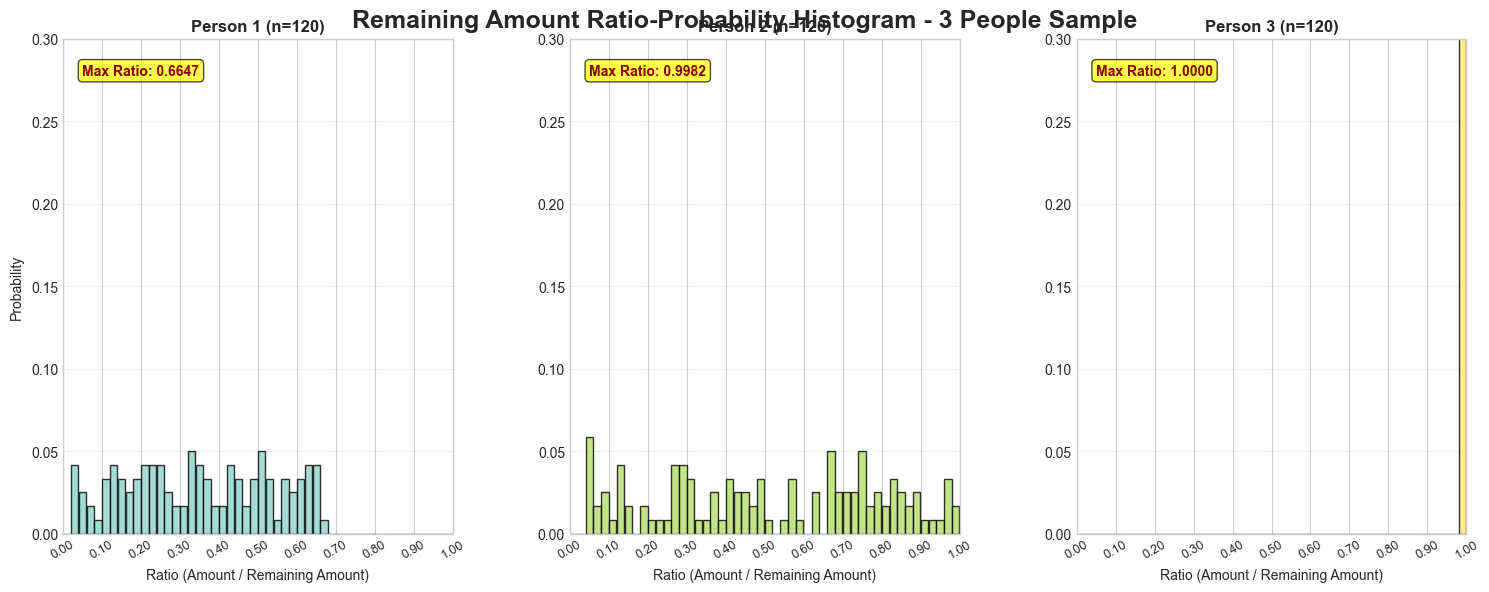


=== Key Statistics (Ratio = Amount / Remaining Amount) - 3 People Sample ===

=== 完整统计表格 ===
  Person  Sample Size Mean Ratio Std Ratio Variance (Ratio²) Max Ratio
Person 1          120     0.3492    0.1866          0.034820    0.6647
Person 2          120     0.5124    0.2834          0.080316    0.9982
Person 3          120     1.0000    0.0000          0.000000    1.0000


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel("E:/gailvlun/SI140A-proj/Data/3/3人总.xls", sheet_name="Sheet1", header=None)

detail_data = df.iloc[1:-1, :3].values.astype(float).round(2)

total_cols = df.shape[1]

if total_cols > 3:
    total_per_round = df.iloc[1:-1, -1].values.astype(float).round(2)
else:
    total_per_round = np.nansum(detail_data, axis=1).round(2)

n_rounds = len(detail_data)
grab_order_labels = [f"Person {i+1}" for i in range(3)] 

ratio_matrix = np.zeros_like(detail_data)
for round_idx in range(min(n_rounds, 10)): 
    person_sum = np.nansum(detail_data[round_idx])
    total = (
        total_per_round[round_idx] if not np.isnan(total_per_round[round_idx]) else 0
    )

for round_idx in range(n_rounds):
    total = (
        total_per_round[round_idx] if not np.isnan(total_per_round[round_idx]) else 0
    )
    remaining = total 

    for order_idx in range(3):
        amount = detail_data[round_idx, order_idx]
        if np.isnan(amount) or remaining <= 0 or total <= 0 or amount < 0:
            ratio = np.nan
        else:
            ratio = (amount / remaining).round(4)
            ratio = min(ratio, 1.0)

        ratio_matrix[round_idx, order_idx] = ratio
        remaining -= amount 

all_valid_ratio = ratio_matrix[~np.isnan(ratio_matrix)]
global_min_ratio = 0.0
global_max_ratio = (
    min(1.0, np.ceil(all_valid_ratio.max() * 10) / 10)
    if len(all_valid_ratio) > 0
    else 1.0
)

bin_width_ratio = 0.02  
bin_edges_ratio = np.arange(
    global_min_ratio, global_max_ratio + bin_width_ratio, bin_width_ratio
)
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle(
    "Remaining Amount Ratio-Probability Histogram - 3 People Sample",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

colors = cm.Set3(np.linspace(0, 1, 3))

for idx, (ax, order_ratio, color) in enumerate(zip(axes.flat, ratio_matrix.T, colors)):
    valid_ratio = order_ratio[~np.isnan(order_ratio)]
    total_samples = len(valid_ratio)
    if total_samples == 0:
        ax.set_visible(False)
        continue

    freq, _ = np.histogram(valid_ratio, bins=bin_edges_ratio)
    prob = freq / total_samples
    bin_centers = bin_edges_ratio[:-1] + bin_width_ratio / 2

    ratio_mean = np.mean(valid_ratio).round(4)
    ratio_std = np.std(valid_ratio).round(4)
    ratio_max = np.max(valid_ratio).round(4) if len(valid_ratio) > 0 else np.nan
    ratio_var = (ratio_std**2).round(6)

    ax.bar(
        bin_centers,
        prob,
        width=bin_width_ratio - 0.001,
        edgecolor="black",
        alpha=0.8,
        color=color,
    )

    if not np.isnan(ratio_max):
        ax.annotate(
            f"Max Ratio: {ratio_max:.4f}",
            xy=(0.05, 0.95),
            xycoords="axes fraction",
            fontsize=10,
            fontweight="bold",
            color="darkred",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
            ha="left",
            va="top",
        )

    ax.set_xlim(global_min_ratio, global_max_ratio)
    ax.xaxis.set_major_locator(MultipleLocator(0.1)) 
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.xaxis.set_minor_locator(MultipleLocator(bin_width_ratio))
    ax.tick_params(axis="x", which="minor", color="#cccccc", labelsize=5)
    ax.tick_params(axis="x", which="major", labelsize=9, rotation=30)

    ax.set_ylim(0, 0.3)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}"))

    ax.set_title(
        f"{grab_order_labels[idx]} (n={total_samples})", fontsize=12, fontweight="bold"
    )
    ax.set_xlabel("Ratio (Amount / Remaining Amount)", fontsize=10, labelpad=5)
    if idx == 0:
        ax.set_ylabel("Probability", fontsize=10, labelpad=5)

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(
    top=0.93,
    hspace=0.5,
    wspace=0.3,
)

plt.savefig(
    "remaining_amount_ratio_probability_3people.png", dpi=300, bbox_inches="tight"
)
plt.show()

print("\n=== Key Statistics (Ratio = Amount / Remaining Amount) - 3 People Sample ===")
order_stats = []
for i in range(3):
    valid_ratio = ratio_matrix[:, i][~np.isnan(ratio_matrix[:, i])]
    if len(valid_ratio) == 0:
        order_stats.append(
            {
                "Person": f"Person {i+1}",
                "Sample Size": 0,
                "Mean Ratio": "N/A",
                "Std Ratio": "N/A",
                "Variance (Ratio²)": "N/A",
                "Max Ratio": "N/A",
            }
        )
        continue
    mean_val = np.mean(valid_ratio).round(4)
    std_val = np.std(valid_ratio).round(4)
    var_val = (std_val**2).round(6)
    max_val = np.max(valid_ratio).round(4)

    order_stats.append(
        {
            "Person": f"Person {i+1}",
            "Sample Size": len(valid_ratio),
            "Mean Ratio": f"{mean_val:.4f}",
            "Std Ratio": f"{std_val:.4f}",
            "Variance (Ratio²)": f"{var_val:.6f}",
            "Max Ratio": f"{max_val:.4f}",
        }
    )

stats_df = pd.DataFrame(order_stats)
print("\n=== 完整统计表格 ===")
print(stats_df.to_string(index=False))


1.The maximum remaining ratio of Person1 (0.6647) is almost identical to 2/n (≈0.6667);

2.Distributions show "uniform distribution" characteristics (a uniform distribution should have approximately equal probabilities across intervals). It give us direction to suspect,the distribution is uniform.

##### **2.box plots**

C:\Users\pc\AppData\Local\Temp\ipykernel_14700\1120045988.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


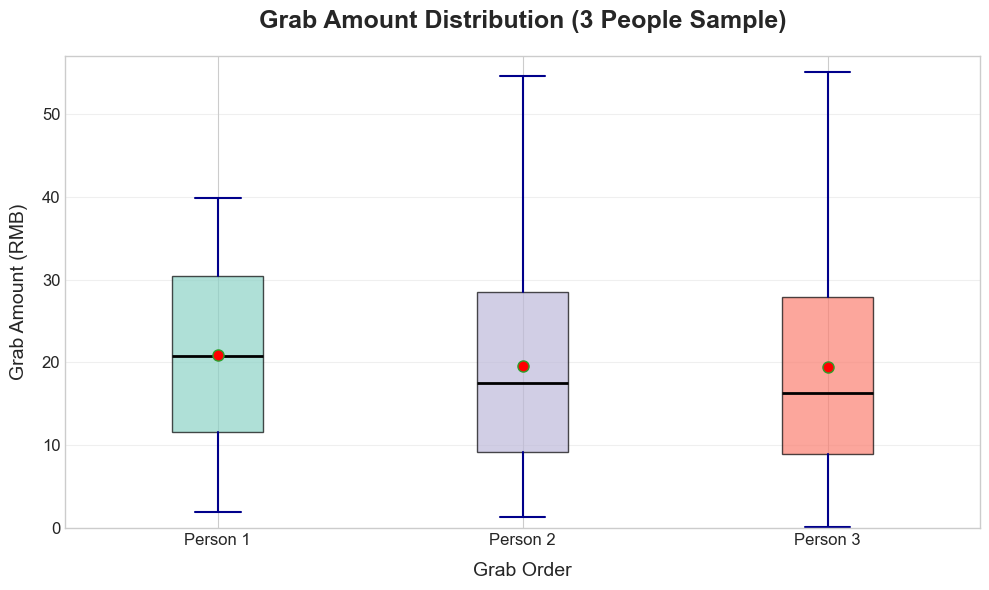

=== 3 People Grab Amount Boxplot Statistics ===
Person 1:
  - Mean: 20.95 RMB
  - Median: 20.77 RMB
  - Maximum: 39.88 RMB
  - Minimum: 2.00 RMB
  - Standard Deviation: 11.20 RMB
Person 2:
  - Mean: 19.63 RMB
  - Median: 17.52 RMB
  - Maximum: 54.62 RMB
  - Minimum: 1.36 RMB
  - Standard Deviation: 12.43 RMB
Person 3:
  - Mean: 19.42 RMB
  - Median: 16.37 RMB
  - Maximum: 55.10 RMB
  - Minimum: 0.10 RMB
  - Standard Deviation: 13.50 RMB


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel("E:/gailvlun/SI140A-proj/Data/3/3人总.xls", sheet_name="Sheet1", header=None)

amount_data = df.iloc[1:-1, :3].values.astype(float).round(2)
grab_order_labels = ["Person 1", "Person 2", "Person 3"]

boxplot_data = []
for i in range(3):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    boxplot_data.append(valid_amount)

all_valid_amount = amount_data[~np.isnan(amount_data)]
global_min_amount = 0.0
global_max_amount = np.ceil(all_valid_amount.max()) if len(all_valid_amount) > 0 else 10

fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(
    boxplot_data,
    labels=grab_order_labels,
    patch_artist=True,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markersize": 8},
    medianprops={"color": "black", "linewidth": 2},
    whiskerprops={"color": "darkblue", "linewidth": 1.5},
    capprops={"color": "darkblue", "linewidth": 1.5},
    flierprops={"marker": "x", "markerfacecolor": "orange", "markersize": 6},
)

colors = ["#8dd3c7", "#bebada", "#fb8072"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title(
    "Grab Amount Distribution (3 People Sample)", fontsize=18, fontweight="bold", pad=20
)
ax.set_xlabel("Grab Order", fontsize=14, labelpad=10)
ax.set_ylabel("Grab Amount (RMB)", fontsize=14, labelpad=10)
ax.set_ylim(global_min_amount, global_max_amount + 1)
ax.tick_params(axis="both", labelsize=12)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("3people_amount_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== 3 People Grab Amount Boxplot Statistics ===")
for i in range(3):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    if len(valid_amount) == 0:
        print(f"{grab_order_labels[i]}: No valid data")
        continue
    print(f"{grab_order_labels[i]}:")
    print(f"  - Mean: {np.mean(valid_amount):.2f} RMB")
    print(f"  - Median: {np.median(valid_amount):.2f} RMB")
    print(f"  - Maximum: {np.max(valid_amount):.2f} RMB")
    print(f"  - Minimum: {np.min(valid_amount):.2f} RMB")
    print(f"  - Standard Deviation: {np.std(valid_amount):.2f} RMB")

##### **3.scatter plots—based**

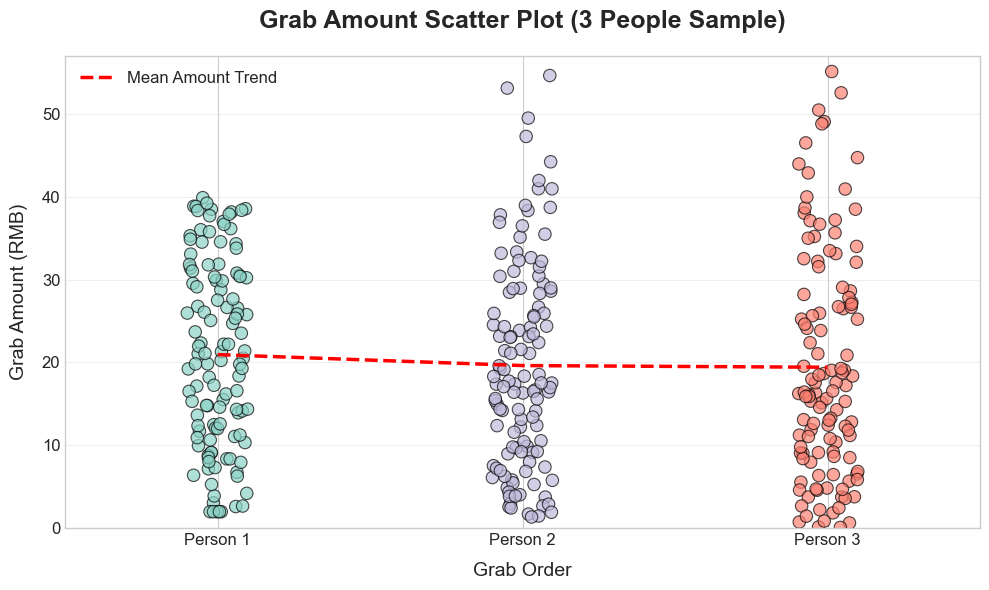

=== Trend of average order amounts for 3 people ===
Person 1 Average Amount:20.95 yuan
Person 2 Average Amount:19.63 yuan
Person 3 Average Amount:19.42 yuan


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel("C:/Users/pc/Desktop/3人总.xls", sheet_name="Sheet1", header=None)

amount_data = df.iloc[1:-1, :3].values.astype(float).round(2)
grab_order_labels = ["Person 1", "Person 2", "Person 3"]

x_data = []
y_data = []
colors_list = []
colors = ["#8dd3c7", "#bebada", "#fb8072"]

for i in range(3):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    x_jitter = [i + 1 + random.uniform(-0.1, 0.1) for _ in valid_amount]
    x_data.extend(x_jitter)
    y_data.extend(valid_amount)
    colors_list.extend([colors[i]] * len(valid_amount))

all_valid_amount = amount_data[~np.isnan(amount_data)]
global_min_amount = 0.0
global_max_amount = np.ceil(all_valid_amount.max()) if len(all_valid_amount) > 0 else 10

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(
    x_data, y_data, c=colors_list, alpha=0.7, s=80, edgecolors="black", linewidths=0.8
)

x_trend = [1, 2, 3]
y_trend = []
for i in range(3):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    mean_amount = np.nanmean(valid_amount) if len(valid_amount) > 0 else np.nan
    y_trend.append(mean_amount)
ax.plot(
    x_trend,
    y_trend,
    color="red",
    linewidth=2.5,
    linestyle="--",
    label="Mean Amount Trend",
)
ax.legend(fontsize=12)

ax.set_title(
    "Grab Amount Scatter Plot (3 People Sample)", fontsize=18, fontweight="bold", pad=20
)
ax.set_xlabel("Grab Order", fontsize=14, labelpad=10)
ax.set_ylabel("Grab Amount (RMB)", fontsize=14, labelpad=10)
ax.set_xlim(0.5, 3.5)
ax.set_ylim(global_min_amount, global_max_amount + 1)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(grab_order_labels)
ax.tick_params(axis="both", labelsize=12)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("3people_amount_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== Trend of average order amounts for 3 people ===")
for i in range(3):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    mean_amount = np.nanmean(valid_amount) if len(valid_amount) > 0 else np.nan
    print(f"{grab_order_labels[i]} Average Amount:{mean_amount:.2f} yuan")


#### **15-person** 60 yuan per red envelope

##### **1.histograms**

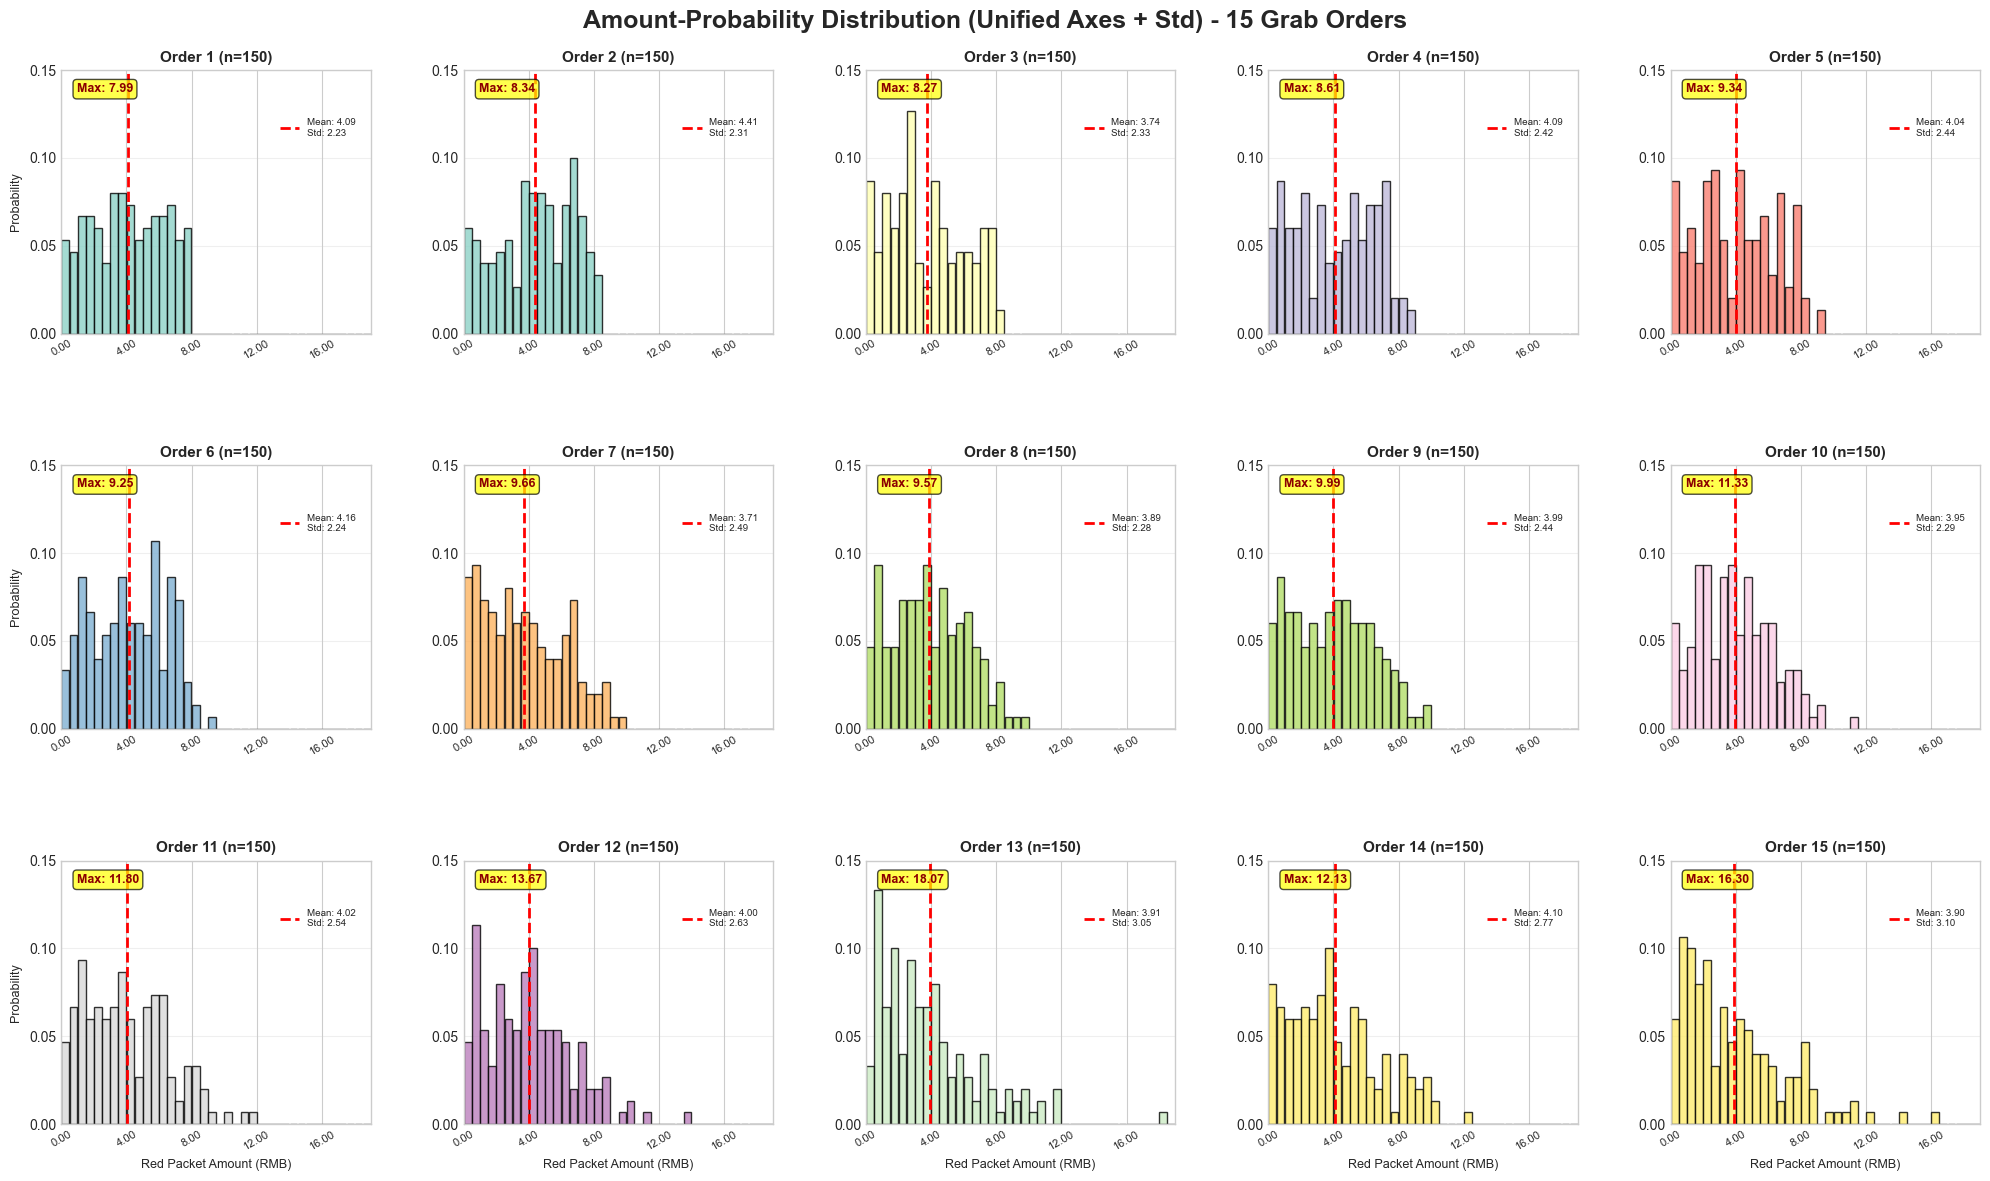

=== Key Statistics (Exact to 0.01 RMB) - 15 Grab Orders ===
Grab Order  Sample Size Mean (RMB) Std (RMB) Variance (RMB²) Max (RMB)
   Order 1          150       4.09      2.23          4.9729      7.99
   Order 2          150       4.41      2.31          5.3361      8.34
   Order 3          150       3.74      2.33          5.4289      8.27
   Order 4          150       4.09      2.42          5.8564      8.61
   Order 5          150       4.04      2.44          5.9536      9.34
   Order 6          150       4.16      2.24          5.0176      9.25
   Order 7          150       3.71      2.49          6.2001      9.66
   Order 8          150       3.89      2.28          5.1984      9.57
   Order 9          150       3.99      2.44          5.9536      9.99
  Order 10          150       3.95      2.29          5.2441     11.33
  Order 11          150       4.02      2.54          6.4516     11.80
  Order 12          150       4.00      2.63          6.9169     13.67
  Order 13       

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel(
    "E:/gailvlun/SI140A-proj/Data/15/15人.xls", sheet_name="Sheet1", header=None
)

grab_order_data = df.iloc[1:-1, :15].values.astype(float).round(2)
all_valid_data = grab_order_data[~np.isnan(grab_order_data)]  
global_min = np.floor(all_valid_data.min()) 
global_max = np.ceil(all_valid_data.max()) 
grab_order_labels = [f"Order {i+1}" for i in range(15)]

bin_width = 0.50
bin_edges = np.arange(global_min, global_max + bin_width, bin_width) 
bins = len(bin_edges) - 1
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle(
    "Amount-Probability Distribution (Unified Axes + Std) - 15 Grab Orders",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

colors = cm.Set3(np.linspace(0, 1, 15))

for idx, (ax, order_data, color) in enumerate(
    zip(axes.flat, grab_order_data.T, colors)
):
    valid_data = order_data[~np.isnan(order_data)].round(2)
    total_samples = len(valid_data)
    if total_samples == 0:
        ax.set_visible(False)  
        continue

    freq, _ = np.histogram(valid_data, bins=bin_edges)
    prob = freq / total_samples  
    bin_centers = bin_edges[:-1] + bin_width / 2

    order_mean = np.mean(valid_data).round(2)
    order_std = np.std(valid_data).round(2)
    order_max = np.max(valid_data).round(2)
    order_var = (order_std**2).round(4) 

    ax.bar(
        bin_centers,
        prob,
        width=bin_width - 0.02,
        edgecolor="black",
        alpha=0.8,
        color=color,
    )

    ax.axvline(
        x=order_mean,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {order_mean:.2f}\nStd: {order_std:.2f}",
    )

    ax.annotate(
        f"Max: {order_max:.2f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=9,
        fontweight="bold",
        color="darkred",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        ha="left",
        va="top",
    )

    ax.set_xlim(global_min, global_max)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=False))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    ax.tick_params(axis="x", which="minor", color="#cccccc", labelsize=6)
    ax.tick_params(axis="x", which="major", labelsize=8, rotation=30)

    ax.set_ylim(0, 0.15)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))  
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}"))

    ax.set_title(
        f"{grab_order_labels[idx]} (n={total_samples})", fontsize=11, fontweight="bold"
    )
    if idx >= 10:
        ax.set_xlabel("Red Packet Amount (RMB)", fontsize=9, labelpad=5)
    if idx % 5 == 0:
        ax.set_ylabel("Probability", fontsize=9, labelpad=5)

    ax.legend(fontsize=7, loc="upper right", bbox_to_anchor=(0.98, 0.85))
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(
    top=0.93,
    hspace=0.5,  
    wspace=0.3, 
)

plt.savefig(
    "unified_axes_amount_probability_with_std.png", dpi=300, bbox_inches="tight"
)
plt.show()

print("=== Key Statistics (Exact to 0.01 RMB) - 15 Grab Orders ===")
order_stats = []
for i in range(15):
    valid_data = grab_order_data.T[i][~np.isnan(grab_order_data.T[i])].round(2)
    if len(valid_data) == 0:
        order_stats.append(
            {
                "Grab Order": f"Order {i+1}",
                "Sample Size": 0,
                "Mean (RMB)": "N/A",
                "Std (RMB)": "N/A",
                "Variance (RMB²)": "N/A", 
                "Max (RMB)": "N/A",
            }
        )
        continue
    mean_val = np.mean(valid_data).round(2)
    std_val = np.std(valid_data).round(2)
    var_val = (std_val**2).round(4)
    max_val = np.max(valid_data).round(2)
    order_stats.append(
        {
            "Grab Order": f"Order {i+1}",
            "Sample Size": len(valid_data),
            "Mean (RMB)": f"{mean_val:.2f}",
            "Std (RMB)": f"{std_val:.2f}",
            "Variance (RMB²)": f"{var_val:.4f}",
            "Max (RMB)": f"{max_val:.2f}",
        }
    )

stats_df = pd.DataFrame(order_stats)
print(stats_df.to_string(index=False))


**amount each person receives/remaining amount** histogram

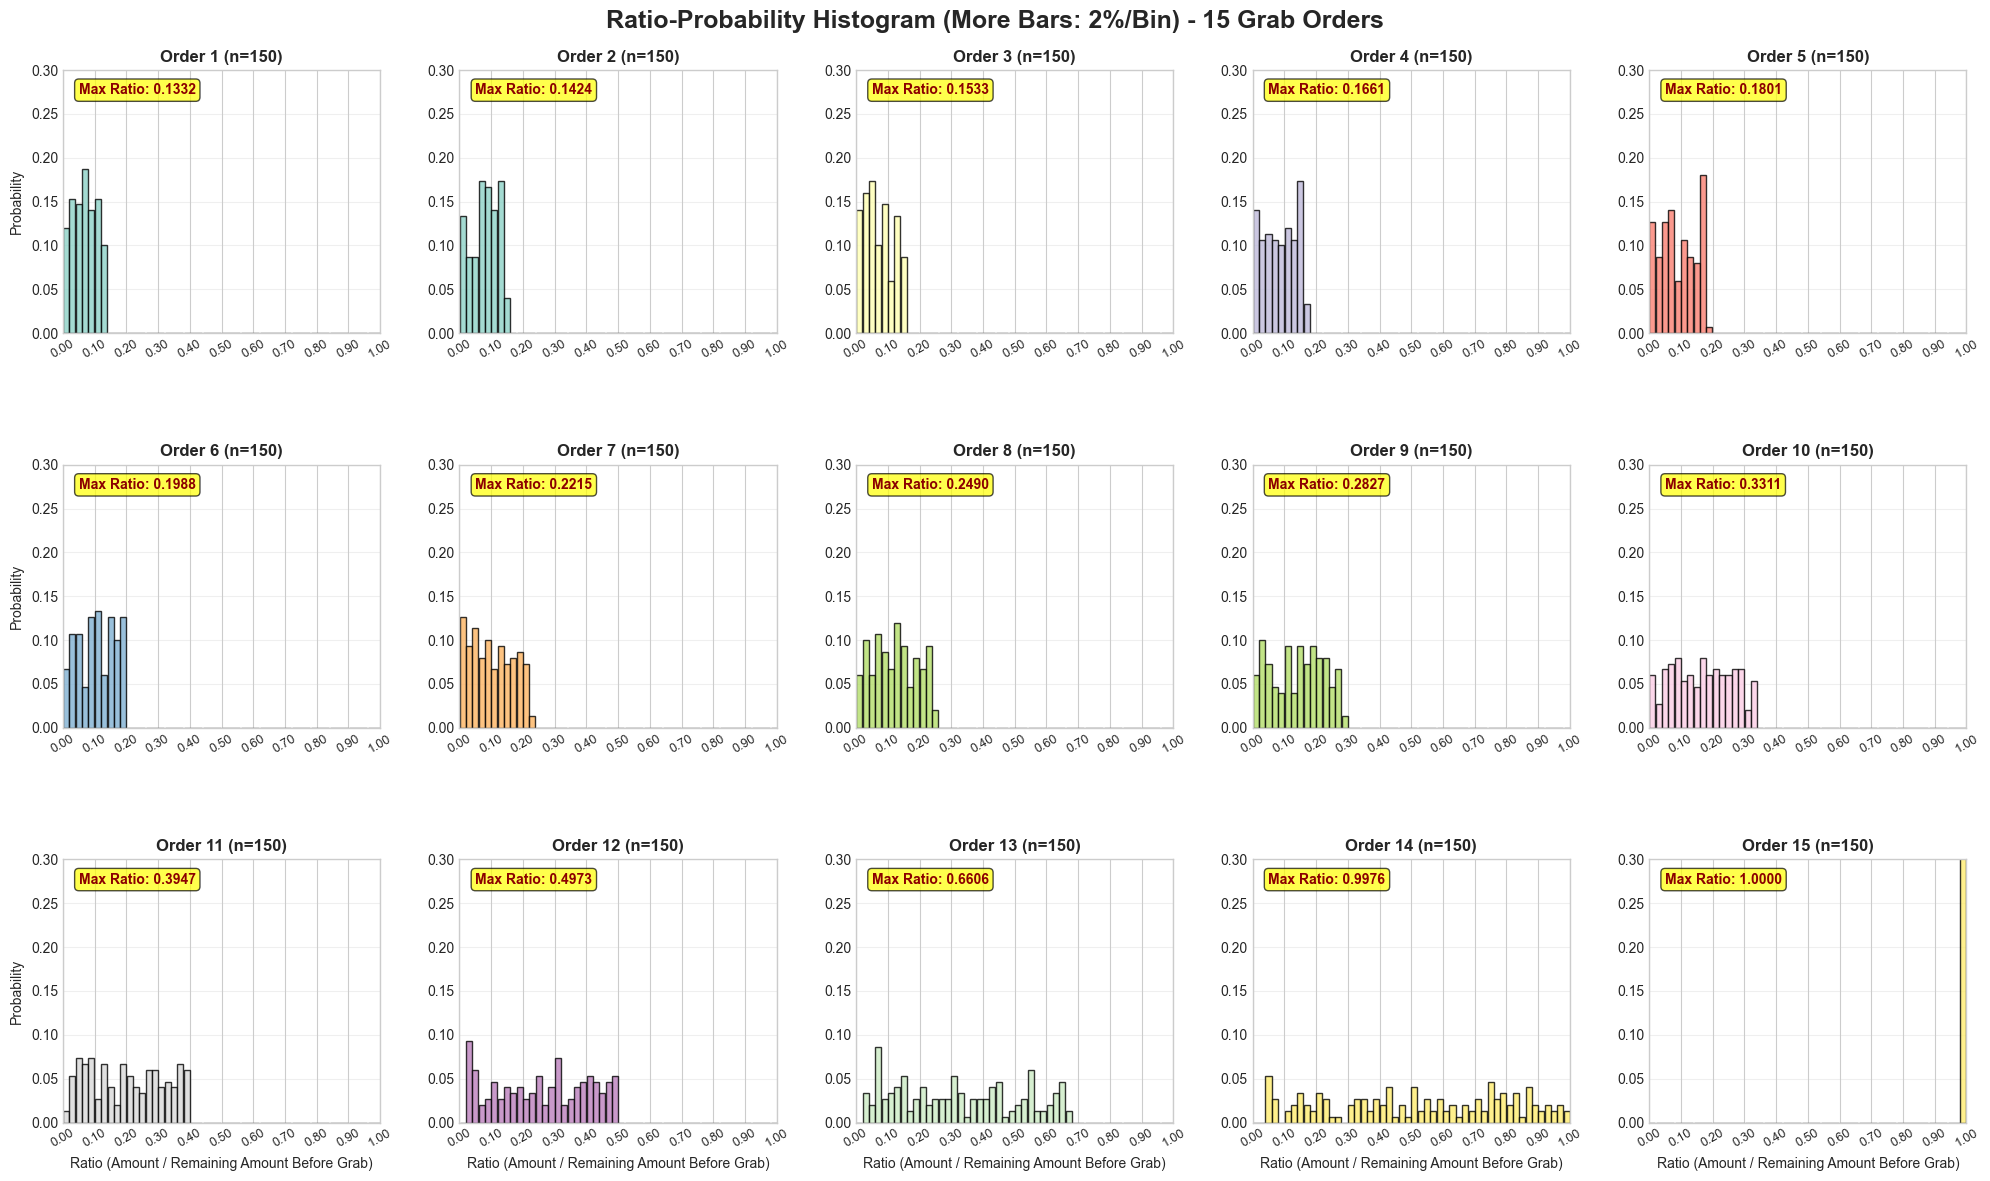

=== Key Statistics (Ratio = Amount / Remaining Amount) - 15 Grab Orders ===
Grab Order  Sample Size Mean Ratio Std Ratio Variance (Ratio²) Max Ratio
   Order 1          150     0.0681    0.0371          0.001376    0.1332
   Order 2          150     0.0788    0.0411          0.001689    0.1424
   Order 3          150     0.0726    0.0448          0.002007    0.1533
   Order 4          150     0.0857    0.0506          0.002560    0.1661
   Order 5          150     0.0926    0.0552          0.003047    0.1801
   Order 6          150     0.1064    0.0575          0.003306    0.1988
   Order 7          150     0.1038    0.0656          0.004303    0.2215
   Order 8          150     0.1219    0.0690          0.004761    0.2490
   Order 9          150     0.1418    0.0804          0.006464    0.2827
  Order 10          150     0.1671    0.0918          0.008427    0.3311
  Order 11          150     0.2027    0.1165          0.013572    0.3947
  Order 12          150     0.2571    0.1488    

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator, MaxNLocator

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel(
    "E:/gailvlun/SI140A-proj/Data/15/15人.xls", sheet_name="Sheet1", header=None
)

detail_data = df.iloc[1:-1, :15].values.astype(float).round(2)
total_per_round = df.iloc[1:-1, 15].values.astype(float).round(2)
n_rounds = len(detail_data)
grab_order_labels = [f"Order {i+1}" for i in range(15)]

ratio_matrix = np.zeros_like(detail_data)
for round_idx in range(n_rounds):
    total = total_per_round[round_idx]
    remaining = total
    for order_idx in range(15):
        amount = detail_data[round_idx, order_idx]
        if np.isnan(amount) or remaining <= 0:
            ratio = np.nan
        else:
            ratio = (amount / remaining).round(4)
        ratio_matrix[round_idx, order_idx] = ratio
        remaining -= amount

all_valid_ratio = ratio_matrix[~np.isnan(ratio_matrix)]
global_min_ratio = 0.0
global_max_ratio = min(1.05, np.ceil(all_valid_ratio.max() * 10) / 10)

bin_width_ratio = 0.02 
bin_edges_ratio = np.arange(
    global_min_ratio, global_max_ratio + bin_width_ratio, bin_width_ratio
)
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle(
    "Ratio-Probability Histogram (More Bars: 2%/Bin) - 15 Grab Orders",
    fontsize=18,
    fontweight="bold",
    y=0.98,
)

colors = cm.Set3(np.linspace(0, 1, 15))

for idx, (ax, order_ratio, color) in enumerate(zip(axes.flat, ratio_matrix.T, colors)):
    valid_ratio = order_ratio[~np.isnan(order_ratio)]
    total_samples = len(valid_ratio)
    if total_samples == 0:
        ax.set_visible(False)
        continue

    freq, _ = np.histogram(valid_ratio, bins=bin_edges_ratio)
    prob = freq / total_samples
    bin_centers = bin_edges_ratio[:-1] + bin_width_ratio / 2

    ratio_mean = np.mean(valid_ratio).round(4)
    ratio_std = np.std(valid_ratio).round(4)
    ratio_max = np.max(valid_ratio).round(4)
    ratio_var = (ratio_std**2).round(6)

    ax.bar(
        bin_centers,
        prob,
        width=bin_width_ratio - 0.001, 
        edgecolor="black",
        alpha=0.8,
        color=color,
    )

    ax.annotate(
        f"Max Ratio: {ratio_max:.4f}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=10,
        fontweight="bold",
        color="darkred",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
        ha="left",
        va="top",
    )

    ax.set_xlim(global_min_ratio, global_max_ratio)
    ax.xaxis.set_major_locator(
        MultipleLocator(0.1)
    )
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.2f}"))
    ax.xaxis.set_minor_locator(
        MultipleLocator(bin_width_ratio)
    )
    ax.tick_params(
        axis="x", which="minor", color="#cccccc", labelsize=5
    )
    ax.tick_params(axis="x", which="major", labelsize=9, rotation=30)

    ax.set_ylim(0, 0.3) 
    ax.yaxis.set_major_locator(MultipleLocator(0.05)) 
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}"))

    ax.set_title(
        f"{grab_order_labels[idx]} (n={total_samples})", fontsize=12, fontweight="bold"
    )
    if idx >= 10:
        ax.set_xlabel(
            "Ratio (Amount / Remaining Amount Before Grab)", fontsize=10, labelpad=5
        )
    if idx % 5 == 0:
        ax.set_ylabel("Probability", fontsize=10, labelpad=5)

    ax.grid(axis="y", alpha=0.3)


plt.tight_layout()
plt.subplots_adjust(
    top=0.93,
    hspace=0.5,
    wspace=0.25,
)

plt.savefig("dense_bars_ratio_probability.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== Key Statistics (Ratio = Amount / Remaining Amount) - 15 Grab Orders ===")
order_stats = []
for i in range(15):
    valid_ratio = ratio_matrix[:, i][~np.isnan(ratio_matrix[:, i])]
    if len(valid_ratio) == 0:
        order_stats.append(
            {
                "Grab Order": f"Order {i+1}",
                "Sample Size": 0,
                "Mean Ratio": "N/A",
                "Std Ratio": "N/A",
                "Variance (Ratio²)": "N/A",
                "Max Ratio": "N/A",
            }
        )
        continue
    mean_val = np.mean(valid_ratio).round(4)
    std_val = np.std(valid_ratio).round(4)
    var_val = (std_val**2).round(6)
    max_val = np.max(valid_ratio).round(4)
    order_stats.append(
        {
            "Grab Order": f"Order {i+1}",
            "Sample Size": len(valid_ratio),
            "Mean Ratio": f"{mean_val:.4f}",
            "Std Ratio": f"{std_val:.4f}",
            "Variance (Ratio²)": f"{var_val:.6f}",
            "Max Ratio": f"{max_val:.4f}",
        }
    )

stats_df = pd.DataFrame(order_stats)
print(stats_df.to_string(index=False))


##### **2.box plots**

C:\Users\pc\AppData\Local\Temp\ipykernel_14700\2865710661.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


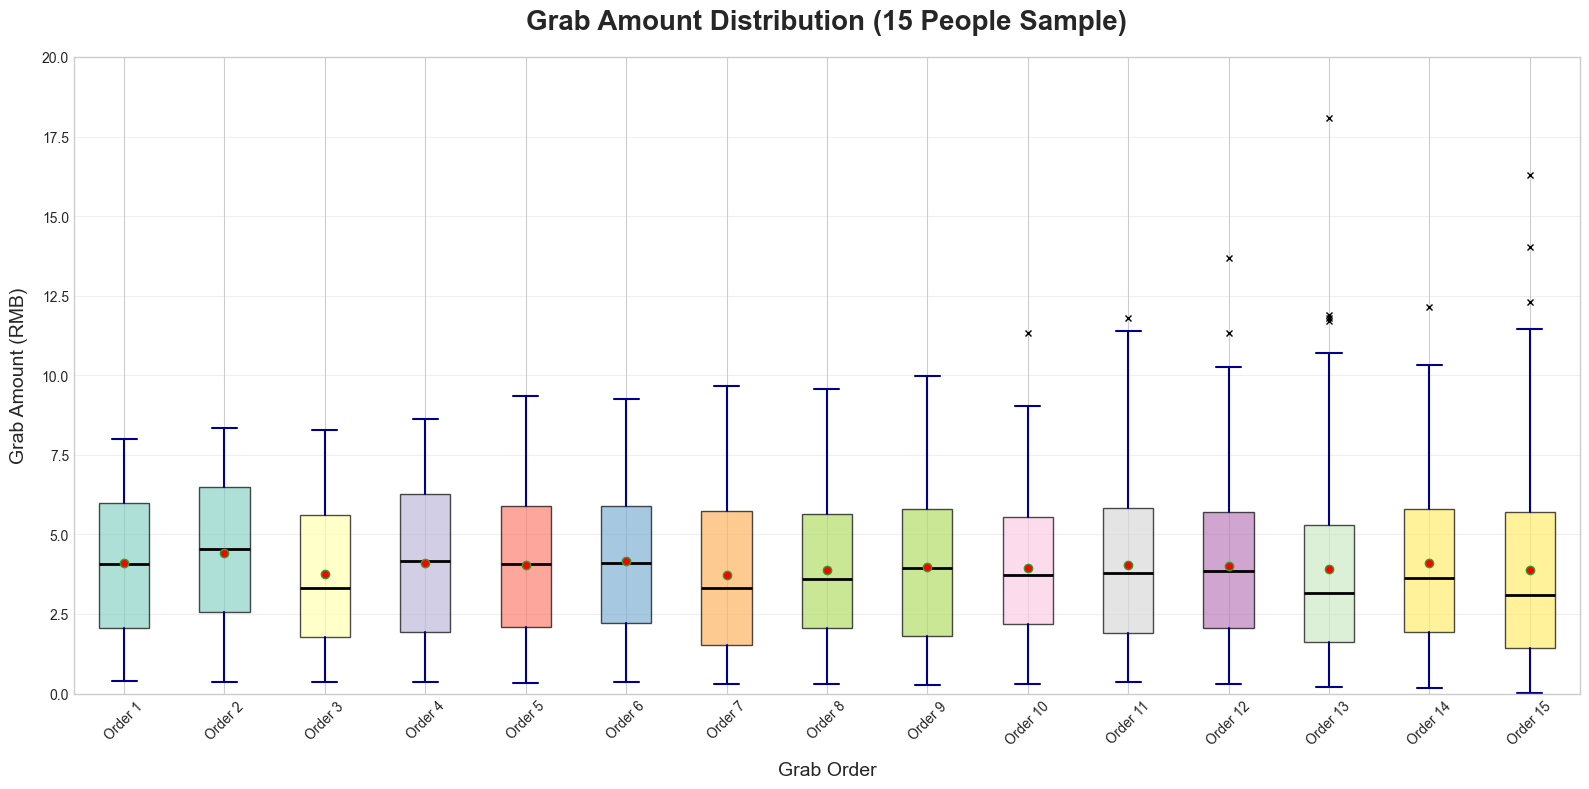

=== Boxplot Statistics of Order Amounts for 15 People ===


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel("E:/gailvlun/SI140A-proj/Data/15/15人.xls", sheet_name="Sheet1", header=None)

amount_data = df.iloc[1:-1, :15].values.astype(float).round(2)
grab_order_labels = [f"Order {i+1}" for i in range(15)] 

boxplot_data = []
for i in range(15):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    boxplot_data.append(valid_amount)

all_valid_amount = amount_data[~np.isnan(amount_data)]
global_min_amount = 0.0
global_max_amount = np.ceil(all_valid_amount.max()) if len(all_valid_amount) > 0 else 10

fig, ax = plt.subplots(figsize=(16, 8))
bp = ax.boxplot(
    boxplot_data,
    labels=grab_order_labels,
    patch_artist=True, 
    showmeans=True, 
    meanprops={"marker": "o", "markerfacecolor": "red", "markersize": 6},
    medianprops={"color": "black", "linewidth": 2},
    whiskerprops={"color": "darkblue", "linewidth": 1.5},
    capprops={"color": "darkblue", "linewidth": 1.5},
    flierprops={"marker": "x", "markerfacecolor": "orange", "markersize": 5},
)

colors = plt.cm.Set3(np.linspace(0, 1, 15))
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title(
    "Grab Amount Distribution (15 People Sample)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Grab Order", fontsize=14, labelpad=10)
ax.set_ylabel("Grab Amount (RMB)", fontsize=14, labelpad=10)
ax.set_ylim(global_min_amount, global_max_amount + 1) 
ax.tick_params(axis="x", rotation=45, labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("15people_amount_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== Boxplot Statistics of Order Amounts for 15 People ===")


##### **3.scatter plots—based**

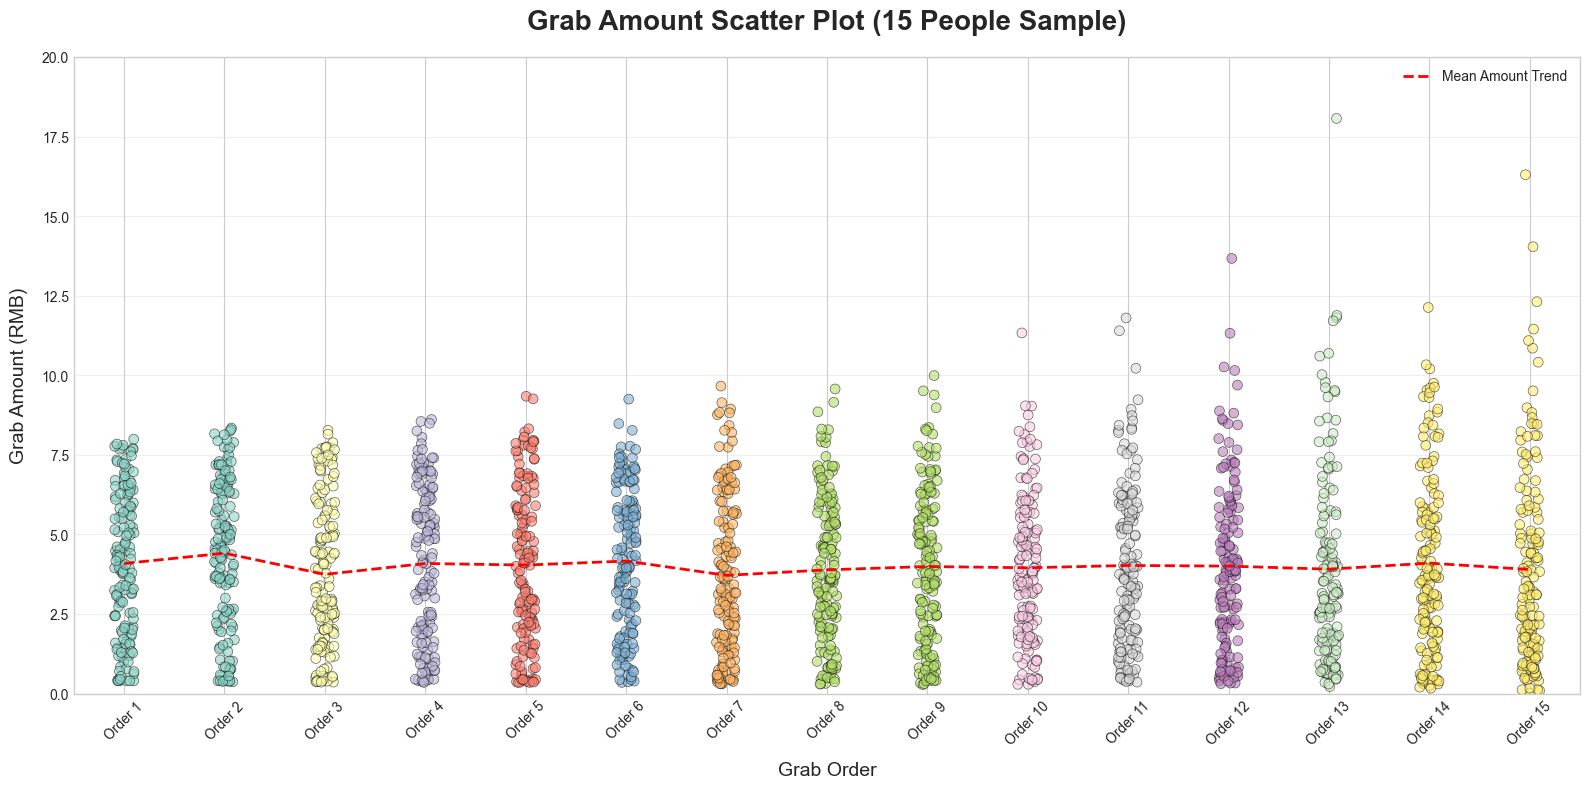

=== Trend of average order amounts for 15 people ===
Mean amount of item 1:4.09 yuan
Mean amount of item 2:4.41 yuan
Mean amount of item 3:3.74 yuan
Mean amount of item 4:4.09 yuan
Mean amount of item 5:4.04 yuan
Mean amount of item 6:4.16 yuan
Mean amount of item 7:3.71 yuan
Mean amount of item 8:3.89 yuan
Mean amount of item 9:3.99 yuan
Mean amount of item 10:3.95 yuan
Mean amount of item 11:4.02 yuan
Mean amount of item 12:4.00 yuan
Mean amount of item 13:3.91 yuan
Mean amount of item 14:4.10 yuan
Mean amount of item 15:3.90 yuan


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_excel("C:/Users/pc/Desktop/15人.xls", sheet_name="Sheet1", header=None)

amount_data = df.iloc[1:-1, :15].values.astype(float).round(2)
grab_order_labels = [f"Order {i+1}" for i in range(15)]

x_data = []
y_data = []
colors_list = []
colors = plt.cm.Set3(np.linspace(0, 1, 15))

for i in range(15):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    x_jitter = [i + 1 + random.uniform(-0.1, 0.1) for _ in valid_amount]
    x_data.extend(x_jitter)
    y_data.extend(valid_amount)
    colors_list.extend([colors[i]] * len(valid_amount))

all_valid_amount = amount_data[~np.isnan(amount_data)]
global_min_amount = 0.0
global_max_amount = np.ceil(all_valid_amount.max()) if len(all_valid_amount) > 0 else 10

fig, ax = plt.subplots(figsize=(16, 8))
scatter = ax.scatter(
    x_data, y_data, c=colors_list, alpha=0.6, s=50, edgecolors="black", linewidths=0.5
)

x_trend = np.arange(1, 16)
y_trend = [
    np.nanmean(amount_data[:, i][~np.isnan(amount_data[:, i])]) for i in range(15)
]
ax.plot(
    x_trend,
    y_trend,
    color="red",
    linewidth=2,
    linestyle="--",
    label="Mean Amount Trend",
)
ax.legend(fontsize=10)

ax.set_title(
    "Grab Amount Scatter Plot (15 People Sample)",
    fontsize=20,
    fontweight="bold",
    pad=20,
)
ax.set_xlabel("Grab Order", fontsize=14, labelpad=10)
ax.set_ylabel("Grab Amount (RMB)", fontsize=14, labelpad=10)
ax.set_xlim(0.5, 15.5)
ax.set_ylim(global_min_amount, global_max_amount + 1)
ax.set_xticks(range(1, 16))
ax.set_xticklabels(grab_order_labels, rotation=45)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("15people_amount_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

print("=== Trend of average order amounts for 15 people ===")
for i in range(15):
    valid_amount = amount_data[:, i][~np.isnan(amount_data[:, i])]
    mean_amount = np.nanmean(valid_amount) if len(valid_amount) > 0 else np.nan
    print(f"Mean amount of item {i+1}:{mean_amount:.2f} yuan")


#### **15-person** 0.6 yuan per red envelope

##### **1.histograms**

**amount each person receives/remaining amount** histogram

##### **2.box plots**

## **3.Distribution**



Prove:In this distribution 


## **4.Model Testing**

## **5.Generative Modeling**

## **6.From Modeling to Decision-Making Policy**

## **7.Further Explorations**